In [1]:
import logging
import os

import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
from tqdm import tqdm_notebook as tqdm

import utils
import model.net as net
from model.data_loader import DataLoader
from evaluate import evaluate, f_score_simple

In [2]:
data_dir = 'data/coNLL/eng/'
model_dir = 'experiments/coNLL/active_learning/'
# data_dir = 'data/kaggle/'
# model_dir = 'experiments/kaggle/base_model/'
json_path = os.path.join(model_dir, 'params.json')
params = utils.Params(json_path)
# use GPU if available
params.cuda = torch.cuda.is_available()

In [3]:
# load data
data_loader = DataLoader(data_dir, params)
data = data_loader.load_data(['train', 'val', 'test'])
train_data = data['train']
val_data = data['val']
test_data = data['test']

# specify the train and val dataset sizes
params.train_size = train_data['size']
params.val_size = val_data['size']
params.test_size = test_data['size']

params.pad_tag_ind = data_loader.tag_map[params.pad_tag]

14041 14041
3250 3250
3453 3453


In [4]:
# Define the model and optimizer
model = net.Net(params).cuda()

In [20]:
# optimizer = optim.SGD(model.parameters(), lr=params.learning_rate, momentum=0.9) # nesterov=True
optimizer = optim.RMSprop(model.parameters(), lr=params.learning_rate)
# fetch loss function and metrics
loss_fn = net.loss_fn
metrics = net.metrics

In [6]:
def model_init():
    global model, optimizer, loss_fn, metrics
    
    model = net.Net(params).cuda()
    # optimizer = optim.SGD(model.parameters(), lr=params.learning_rate, momentum=0.9) # nesterov=True
    optimizer = optim.RMSprop(model.parameters(), lr=params.learning_rate)
    # fetch loss function and metrics
    loss_fn = net.loss_fn
    metrics = net.metrics
    
    # Set the logger
    utils.set_logger(os.path.join(model_dir, 'train.log'))
    
def save_model(save_file='init'):
    filepath = os.path.join(model_dir, save_file + '.pth.tar')
    if not os.path.exists(model_dir):
        print("Model Directory does not exist! Making directory {}".format(checkpoint))
        os.mkdir(model_dir)
    else:
        print("Model Directory exists! ")
    
    state = {'state_dict': model.state_dict(), 'optim_dict' : optimizer.state_dict()}    
    torch.save(state, filepath)


def restore_model(restore_file = 'init'):
    checkpoint = os.path.join(model_dir, restore_file + '.pth.tar')
    if not os.path.exists(checkpoint):
        raise Exception("File doesn't exist {}".format(checkpoint))
    checkpoint = torch.load(checkpoint)
    model.load_state_dict(checkpoint['state_dict'])

In [7]:
def train(model, optimizer, loss_fn, data_iterator, metrics, params, num_steps):
    """Train the model on `num_steps` batches
    Args:
        model: (torch.nn.Module) the neural network
        optimizer: (torch.optim) optimizer for parameters of model
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        data_iterator: (generator) a generator that generates batches of data and labels and sequence lenghts in batch
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
        num_steps: (int) number of batches to train on, each of size params.batch_size
    """

    # set model to training mode
    model.train()

    # summary for current training loop and a running average object for loss
    summ = []
    loss_avg = utils.RunningAverage()
    
    # Use tqdm for progress bar
    t = trange(num_steps) 
    for i in t:
        # fetch the next training batch
        train_batch, labels_batch,_ = next(data_iterator)

        # compute model output and loss
        output_batch = model(train_batch)
        loss = loss_fn(output_batch, labels_batch)

        # clear previous gradients, compute gradients of all variables wrt loss
        optimizer.zero_grad()
        loss.backward()

        # performs updates using calculated gradients
        optimizer.step()

        # update the average loss
        loss_avg.update(loss.item())
        t.set_postfix(loss='{:05.3f}'.format(loss_avg()))

    # compute sample metrics on the last batch of the epoch
    # extract data from torch Variable, move to cpu, convert to numpy arrays
    output_batch = output_batch.data.cpu().numpy()
    labels_batch = labels_batch.data.cpu().numpy()

    # compute all metrics on this batch
    summary_batch = {metric:metrics[metric](output_batch, labels_batch, params) for metric in metrics}
    summary_batch['loss'] = loss.item()
    summ.append(summary_batch)
    
    metrics_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]} 
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())
    logging.info("- Train metrics: " + metrics_string)

In [8]:
def train_model(data, labels, step=None):
    '''step may indicate acuistion iteration and can be used for logging'''
    print('Training data size: ' + str(len(data)))
    
    data_dict = {'data':data, 'labels':labels, 'size':len(data)} 
    num_steps = (len(data) + 1) // model.params.batch_size
    
    for epoch in range(model.params.num_epochs):
        # run one epoch
        logging.info("Epoch {}/{}".format(epoch + 1, model.params.num_epochs))
        data_iterator = data_loader.data_iterator(data_dict, model.params, shuffle=True)
        train(model, optimizer, loss_fn, data_iterator, metrics, model.params, num_steps)


In [9]:
def test_model(data, labels, step=None):
    # Evaluate for one epoch on validation set
    # set on eval mode
    model.eval()
    
    num_steps = (len(data) + 1) // model.params.batch_size
    data_dict = {'data':data, 'labels':labels, 'size':len(data)} 
    
    # data_iterator = data_loader.data_iterator(data_dict, model.params, shuffle=False)
    test_metrics = evaluate(model, loss_fn, data_dict, metrics, data_loader, params, num_steps)
    
    # val_acc = val_metrics['accuracy']
    test_acc = test_metrics['f1']
    return test_acc

In [15]:
def mnlp(pool_data, num_samples, step=None):
    # set in test mode
    model.eval()
    
    data_dict = {'data':pool_data, 'labels':[1]*len(pool_data), 'size':len(pool_data)}
    data_iterator = data_loader.data_iterator(data_dict, model.params, shuffle=False)
    
    num_steps = (len(pool_data) + 1) // model.params.batch_size
    
    print('MNLP over Pool Data')
    probs = np.array([])
    # Use tqdm for progress bar
    t = trange(num_steps) 
    for i in t:
        # fetch the next training batch
        data_batch, labels_batch, seql = next(data_iterator)
        # compute model output and loss
        output_batch = model(data_batch)
        output_batch = output_batch.data.cpu().numpy()
        
        outputs = np.max(output_batch, axis=1) # shape: seql*batch_size
        outputs = outputs.reshape((len(labels_batch), -1))
        assert len(seql) == len(outputs), 'lengths of seql and outputs should match'
        # mask beyond sequence length to 0
        for i in range(len(outputs)):
            outputs[i][seql[i]:] = 0
        
        p = np.sum(outputs, axis=1) / seql
        probs = np.hstack((probs, p))
    
    pos = np.argpartition(probs, num_samples)[:num_samples]
    return pos

In [16]:
a = ActiveLearner(train_data['data'], train_data['labels'], test_data['data'], test_data['labels'], 
                  model_init, train_model, test_model, save_model, restore_model, init_num_samples=500)

Epoch 1/15
 19%|█▉        | 19/100 [00:00<00:00, 98.54it/s, loss=0.761] 

Picked 500 datapoints
Size of updated unsupervised pool = 13541

Initial Training
Training data size: 500


100%|██████████| 100/100 [00:00<00:00, 204.52it/s, loss=0.715]
- Train metrics: accuracy: 0.818 ; loss: 0.720
Epoch 2/15
100%|██████████| 100/100 [00:00<00:00, 212.15it/s, loss=0.605]
- Train metrics: accuracy: 0.844 ; loss: 0.579
Epoch 3/15
100%|██████████| 100/100 [00:00<00:00, 212.10it/s, loss=0.541]
- Train metrics: accuracy: 0.911 ; loss: 0.286
Epoch 4/15
100%|██████████| 100/100 [00:00<00:00, 210.94it/s, loss=0.481]
- Train metrics: accuracy: 0.829 ; loss: 0.502
Epoch 5/15
100%|██████████| 100/100 [00:00<00:00, 210.69it/s, loss=0.420]
- Train metrics: accuracy: 0.864 ; loss: 0.447
Epoch 6/15
100%|██████████| 100/100 [00:00<00:00, 211.16it/s, loss=0.373]
- Train metrics: accuracy: 0.825 ; loss: 0.450
Epoch 7/15
100%|██████████| 100/100 [00:00<00:00, 211.74it/s, loss=0.329]
- Train metrics: accuracy: 0.898 ; loss: 0.339
Epoch 8/15
100%|██████████| 100/100 [00:00<00:00, 211.23it/s, loss=0.282]
- Train metrics: accuracy: 0.847 ; loss: 0.355
Epoch 9/15
100%|██████████| 100/100 [00:00<

Model Directory exists! 
Successfully saved the initial model


In [21]:
y_random = a.run(50, [random_acq, mnlp], pool_subset_count=1000, num_samples=10)

Recovered Saved Model


- Eval metrics : accuracy: 0.806 ; loss: 0.787 ; f1: 33.826
Epoch 1/15
 21%|██        | 21/102 [00:00<00:00, 107.76it/s, loss=0.071]


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 1 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13531
Training data size: 510


100%|██████████| 102/102 [00:00<00:00, 208.50it/s, loss=0.069]
- Train metrics: accuracy: 0.986 ; loss: 0.067
Epoch 2/15
100%|██████████| 102/102 [00:00<00:00, 207.84it/s, loss=0.037]
- Train metrics: accuracy: 1.000 ; loss: 0.022
Epoch 3/15
100%|██████████| 102/102 [00:00<00:00, 207.86it/s, loss=0.022]
- Train metrics: accuracy: 0.989 ; loss: 0.028
Epoch 4/15
100%|██████████| 102/102 [00:00<00:00, 208.91it/s, loss=0.015]
- Train metrics: accuracy: 1.000 ; loss: 0.013
Epoch 5/15
100%|██████████| 102/102 [00:00<00:00, 208.97it/s, loss=0.011]
- Train metrics: accuracy: 1.000 ; loss: 0.022
Epoch 6/15
100%|██████████| 102/102 [00:00<00:00, 207.96it/s, loss=0.011]
- Train metrics: accuracy: 1.000 ; loss: 0.006
Epoch 7/15
100%|██████████| 102/102 [00:00<00:00, 208.00it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.006
Epoch 8/15
100%|██████████| 102/102 [00:00<00:00, 207.41it/s, loss=0.004]
- Train metrics: accuracy: 1.000 ; loss: 0.004
Epoch 9/15
100%|██████████| 102/102 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 2 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13521
Training data size: 520


100%|██████████| 104/104 [00:00<00:00, 208.02it/s, loss=0.034]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 104/104 [00:00<00:00, 208.10it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 104/104 [00:00<00:00, 209.22it/s, loss=0.003]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 104/104 [00:00<00:00, 207.85it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 104/104 [00:00<00:00, 207.85it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.001
Epoch 6/15
100%|██████████| 104/104 [00:00<00:00, 208.27it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 104/104 [00:00<00:00, 208.41it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 104/104 [00:00<00:00, 208.73it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 104/104 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 3 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13511
Training data size: 530


100%|██████████| 106/106 [00:00<00:00, 209.88it/s, loss=0.017]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 106/106 [00:00<00:00, 210.12it/s, loss=0.004]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 106/106 [00:00<00:00, 207.48it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 106/106 [00:00<00:00, 209.52it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 106/106 [00:00<00:00, 209.03it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 106/106 [00:00<00:00, 209.52it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 106/106 [00:00<00:00, 209.23it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 106/106 [00:00<00:00, 207.74it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 106/106 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 4 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13501
Training data size: 540


100%|██████████| 108/108 [00:00<00:00, 210.23it/s, loss=0.038]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 108/108 [00:00<00:00, 208.56it/s, loss=0.009]
- Train metrics: accuracy: 1.000 ; loss: 0.001
Epoch 3/15
100%|██████████| 108/108 [00:00<00:00, 207.95it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 108/108 [00:00<00:00, 207.60it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.003
Epoch 5/15
100%|██████████| 108/108 [00:00<00:00, 208.99it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 108/108 [00:00<00:00, 207.61it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 108/108 [00:00<00:00, 208.84it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 108/108 [00:00<00:00, 207.66it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 108/108 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 5 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13491
Training data size: 550


100%|██████████| 110/110 [00:00<00:00, 208.11it/s, loss=0.025]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 110/110 [00:00<00:00, 207.57it/s, loss=0.003]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 110/110 [00:00<00:00, 206.95it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 110/110 [00:00<00:00, 207.10it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 110/110 [00:00<00:00, 205.83it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 110/110 [00:00<00:00, 206.76it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 110/110 [00:00<00:00, 207.97it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 110/110 [00:00<00:00, 205.55it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 110/110 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 6 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13481
Training data size: 560


100%|██████████| 112/112 [00:00<00:00, 206.30it/s, loss=0.023]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 112/112 [00:00<00:00, 206.75it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 112/112 [00:00<00:00, 207.68it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 112/112 [00:00<00:00, 207.62it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 112/112 [00:00<00:00, 206.76it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 112/112 [00:00<00:00, 207.28it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 112/112 [00:00<00:00, 205.98it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 112/112 [00:00<00:00, 206.55it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 112/112 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 7 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13471
Training data size: 570


100%|██████████| 114/114 [00:00<00:00, 206.81it/s, loss=0.042]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 114/114 [00:00<00:00, 207.83it/s, loss=0.011]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 114/114 [00:00<00:00, 206.64it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 114/114 [00:00<00:00, 205.51it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 114/114 [00:00<00:00, 205.88it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.001
Epoch 6/15
100%|██████████| 114/114 [00:00<00:00, 206.15it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 114/114 [00:00<00:00, 207.01it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 114/114 [00:00<00:00, 206.78it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 114/114 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 8 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13461
Training data size: 580


100%|██████████| 116/116 [00:00<00:00, 206.11it/s, loss=0.028]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 116/116 [00:00<00:00, 208.58it/s, loss=0.006]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 116/116 [00:00<00:00, 207.23it/s, loss=0.003]
- Train metrics: accuracy: 1.000 ; loss: 0.001
Epoch 4/15
100%|██████████| 116/116 [00:00<00:00, 207.80it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 116/116 [00:00<00:00, 207.07it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 116/116 [00:00<00:00, 206.39it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 116/116 [00:00<00:00, 207.00it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 116/116 [00:00<00:00, 205.10it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 116/116 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 9 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13451
Training data size: 590


100%|██████████| 118/118 [00:00<00:00, 207.65it/s, loss=0.013]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 118/118 [00:00<00:00, 206.69it/s, loss=0.004]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 118/118 [00:00<00:00, 207.77it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 118/118 [00:00<00:00, 207.73it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 118/118 [00:00<00:00, 207.16it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 118/118 [00:00<00:00, 207.70it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 118/118 [00:00<00:00, 206.72it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 118/118 [00:00<00:00, 206.15it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 118/118 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 10 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13441
Training data size: 600


100%|██████████| 120/120 [00:00<00:00, 206.09it/s, loss=0.014]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 120/120 [00:00<00:00, 206.77it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 120/120 [00:00<00:00, 205.72it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 120/120 [00:00<00:00, 206.93it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 120/120 [00:00<00:00, 207.14it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 120/120 [00:00<00:00, 206.96it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 120/120 [00:00<00:00, 207.37it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 120/120 [00:00<00:00, 207.97it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 120/120 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 11 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13431
Training data size: 610


100%|██████████| 122/122 [00:00<00:00, 206.06it/s, loss=0.009]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 122/122 [00:00<00:00, 205.61it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 122/122 [00:00<00:00, 207.43it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 122/122 [00:00<00:00, 208.03it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 122/122 [00:00<00:00, 206.95it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 122/122 [00:00<00:00, 207.20it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 122/122 [00:00<00:00, 206.67it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 122/122 [00:00<00:00, 206.10it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 122/122 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 12 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13421
Training data size: 620


100%|██████████| 124/124 [00:00<00:00, 207.00it/s, loss=0.011]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 124/124 [00:00<00:00, 207.27it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 124/124 [00:00<00:00, 206.55it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 124/124 [00:00<00:00, 207.40it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 124/124 [00:00<00:00, 206.83it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 124/124 [00:00<00:00, 206.91it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 124/124 [00:00<00:00, 206.97it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 124/124 [00:00<00:00, 207.82it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 124/124 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 13 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13411
Training data size: 630


100%|██████████| 126/126 [00:00<00:00, 207.88it/s, loss=0.030]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 126/126 [00:00<00:00, 207.05it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 126/126 [00:00<00:00, 207.78it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 126/126 [00:00<00:00, 207.29it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 126/126 [00:00<00:00, 207.65it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 126/126 [00:00<00:00, 204.60it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 126/126 [00:00<00:00, 206.73it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 126/126 [00:00<00:00, 204.81it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 126/126 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 14 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13401
Training data size: 640


100%|██████████| 128/128 [00:00<00:00, 206.18it/s, loss=0.009]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 128/128 [00:00<00:00, 205.71it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 128/128 [00:00<00:00, 205.87it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 128/128 [00:00<00:00, 206.72it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 128/128 [00:00<00:00, 208.13it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 128/128 [00:00<00:00, 207.08it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 128/128 [00:00<00:00, 207.59it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 128/128 [00:00<00:00, 206.56it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 128/128 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 15 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13391
Training data size: 650


100%|██████████| 130/130 [00:00<00:00, 207.89it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 130/130 [00:00<00:00, 205.95it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 130/130 [00:00<00:00, 205.65it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 130/130 [00:00<00:00, 206.01it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 130/130 [00:00<00:00, 207.01it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 130/130 [00:00<00:00, 207.20it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 130/130 [00:00<00:00, 204.79it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 130/130 [00:00<00:00, 206.92it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 130/130 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 16 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13381
Training data size: 660


100%|██████████| 132/132 [00:00<00:00, 207.96it/s, loss=0.017]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 132/132 [00:00<00:00, 206.94it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 132/132 [00:00<00:00, 206.14it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 132/132 [00:00<00:00, 206.52it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 132/132 [00:00<00:00, 208.20it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 132/132 [00:00<00:00, 207.18it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 132/132 [00:00<00:00, 207.07it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 132/132 [00:00<00:00, 205.05it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 132/132 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 17 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13371
Training data size: 670


100%|██████████| 134/134 [00:00<00:00, 208.53it/s, loss=0.014]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 134/134 [00:00<00:00, 206.61it/s, loss=0.003]
- Train metrics: accuracy: 1.000 ; loss: 0.001
Epoch 3/15
100%|██████████| 134/134 [00:00<00:00, 207.92it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 134/134 [00:00<00:00, 206.60it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 134/134 [00:00<00:00, 206.55it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 134/134 [00:00<00:00, 206.14it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 134/134 [00:00<00:00, 207.38it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 134/134 [00:00<00:00, 206.46it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 134/134 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 18 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13361
Training data size: 680


100%|██████████| 136/136 [00:00<00:00, 208.46it/s, loss=0.027]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 136/136 [00:00<00:00, 206.61it/s, loss=0.003]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 136/136 [00:00<00:00, 207.42it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 136/136 [00:00<00:00, 206.16it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 136/136 [00:00<00:00, 205.86it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 136/136 [00:00<00:00, 207.60it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 136/136 [00:00<00:00, 206.62it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 136/136 [00:00<00:00, 207.40it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 136/136 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 19 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13351
Training data size: 690


100%|██████████| 138/138 [00:00<00:00, 206.97it/s, loss=0.023]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 138/138 [00:00<00:00, 206.45it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 138/138 [00:00<00:00, 207.30it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 138/138 [00:00<00:00, 207.76it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 138/138 [00:00<00:00, 206.19it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 138/138 [00:00<00:00, 206.67it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 138/138 [00:00<00:00, 207.77it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 138/138 [00:00<00:00, 205.62it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 138/138 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 20 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13341
Training data size: 700


100%|██████████| 140/140 [00:00<00:00, 208.88it/s, loss=0.018]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 140/140 [00:00<00:00, 207.04it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 140/140 [00:00<00:00, 208.09it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 140/140 [00:00<00:00, 206.41it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 140/140 [00:00<00:00, 207.79it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 140/140 [00:00<00:00, 205.42it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 140/140 [00:00<00:00, 207.38it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 140/140 [00:00<00:00, 207.36it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 140/140 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 21 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13331
Training data size: 710


100%|██████████| 142/142 [00:00<00:00, 207.02it/s, loss=0.011]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 142/142 [00:00<00:00, 207.65it/s, loss=0.004]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 142/142 [00:00<00:00, 208.19it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 142/142 [00:00<00:00, 206.26it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 142/142 [00:00<00:00, 207.88it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 142/142 [00:00<00:00, 189.15it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 142/142 [00:00<00:00, 189.74it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 142/142 [00:00<00:00, 174.34it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 142/142 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 22 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13321
Training data size: 720


100%|██████████| 144/144 [00:00<00:00, 207.60it/s, loss=0.016]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 144/144 [00:00<00:00, 208.01it/s, loss=0.003]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 144/144 [00:00<00:00, 207.27it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 144/144 [00:00<00:00, 207.72it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 144/144 [00:00<00:00, 206.71it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 144/144 [00:00<00:00, 207.48it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 144/144 [00:00<00:00, 206.22it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 144/144 [00:00<00:00, 206.77it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 144/144 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 23 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13311
Training data size: 730


100%|██████████| 146/146 [00:00<00:00, 208.38it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 146/146 [00:00<00:00, 207.04it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 146/146 [00:00<00:00, 197.37it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 146/146 [00:00<00:00, 207.66it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 146/146 [00:00<00:00, 208.05it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 146/146 [00:00<00:00, 208.25it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 146/146 [00:00<00:00, 207.64it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 146/146 [00:00<00:00, 207.34it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 146/146 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 24 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13301
Training data size: 740


100%|██████████| 148/148 [00:00<00:00, 208.14it/s, loss=0.010]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 148/148 [00:00<00:00, 207.14it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 148/148 [00:00<00:00, 206.59it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 148/148 [00:00<00:00, 207.96it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 148/148 [00:00<00:00, 206.61it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 148/148 [00:00<00:00, 207.98it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 148/148 [00:00<00:00, 208.59it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 148/148 [00:00<00:00, 208.26it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 148/148 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 25 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13291
Training data size: 750


100%|██████████| 150/150 [00:00<00:00, 207.41it/s, loss=0.006]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 150/150 [00:00<00:00, 206.71it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 150/150 [00:00<00:00, 206.36it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 150/150 [00:00<00:00, 207.44it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 150/150 [00:00<00:00, 205.33it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 150/150 [00:00<00:00, 208.14it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 150/150 [00:00<00:00, 207.96it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 150/150 [00:00<00:00, 207.47it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 150/150 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 26 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13281
Training data size: 760


100%|██████████| 152/152 [00:00<00:00, 202.95it/s, loss=0.029]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 152/152 [00:00<00:00, 206.28it/s, loss=0.008]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 152/152 [00:00<00:00, 207.76it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 152/152 [00:00<00:00, 206.73it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 152/152 [00:00<00:00, 206.87it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 152/152 [00:00<00:00, 207.24it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 152/152 [00:00<00:00, 207.48it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 152/152 [00:00<00:00, 206.99it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 152/152 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 27 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13271
Training data size: 770


100%|██████████| 154/154 [00:00<00:00, 206.96it/s, loss=0.011]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 154/154 [00:00<00:00, 206.90it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 154/154 [00:00<00:00, 206.99it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 154/154 [00:00<00:00, 208.17it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 154/154 [00:00<00:00, 208.41it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 154/154 [00:00<00:00, 207.78it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 154/154 [00:00<00:00, 207.36it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 154/154 [00:00<00:00, 208.32it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 154/154 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 28 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13261
Training data size: 780


100%|██████████| 156/156 [00:00<00:00, 208.14it/s, loss=0.023]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 156/156 [00:00<00:00, 207.78it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 156/156 [00:00<00:00, 207.43it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 156/156 [00:00<00:00, 207.70it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 156/156 [00:00<00:00, 207.24it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 156/156 [00:00<00:00, 207.17it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 156/156 [00:00<00:00, 207.93it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 156/156 [00:00<00:00, 207.62it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 156/156 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 29 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13251
Training data size: 790


100%|██████████| 158/158 [00:00<00:00, 208.30it/s, loss=0.016]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 158/158 [00:00<00:00, 207.68it/s, loss=0.006]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 158/158 [00:00<00:00, 208.94it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 158/158 [00:00<00:00, 207.19it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 158/158 [00:00<00:00, 206.30it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 158/158 [00:00<00:00, 206.94it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 158/158 [00:00<00:00, 206.85it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 158/158 [00:00<00:00, 207.17it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 158/158 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 30 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13241
Training data size: 800


100%|██████████| 160/160 [00:00<00:00, 207.62it/s, loss=0.009]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 160/160 [00:00<00:00, 207.91it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 160/160 [00:00<00:00, 207.02it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 160/160 [00:00<00:00, 207.10it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 160/160 [00:00<00:00, 207.85it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 160/160 [00:00<00:00, 205.92it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 160/160 [00:00<00:00, 206.41it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 160/160 [00:00<00:00, 207.28it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 160/160 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 31 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13231
Training data size: 810


100%|██████████| 162/162 [00:00<00:00, 208.74it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 162/162 [00:00<00:00, 208.55it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 162/162 [00:00<00:00, 206.73it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 162/162 [00:00<00:00, 208.15it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 162/162 [00:00<00:00, 207.62it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 162/162 [00:00<00:00, 207.01it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 162/162 [00:00<00:00, 207.58it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 162/162 [00:00<00:00, 206.41it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 162/162 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 32 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13221
Training data size: 820


100%|██████████| 164/164 [00:00<00:00, 207.38it/s, loss=0.028]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 164/164 [00:00<00:00, 206.90it/s, loss=0.006]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 164/164 [00:00<00:00, 207.75it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 164/164 [00:00<00:00, 208.14it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 164/164 [00:00<00:00, 206.67it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 164/164 [00:00<00:00, 206.97it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 164/164 [00:00<00:00, 207.98it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 164/164 [00:00<00:00, 195.65it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 164/164 [00:01<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 33 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13211
Training data size: 830


100%|██████████| 166/166 [00:00<00:00, 205.94it/s, loss=0.014]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 166/166 [00:00<00:00, 207.66it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 166/166 [00:00<00:00, 207.31it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 166/166 [00:00<00:00, 208.83it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 166/166 [00:00<00:00, 207.06it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 166/166 [00:00<00:00, 207.20it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 166/166 [00:00<00:00, 208.79it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 166/166 [00:00<00:00, 204.99it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 166/166 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 34 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13201
Training data size: 840


100%|██████████| 168/168 [00:00<00:00, 208.30it/s, loss=0.013]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 168/168 [00:00<00:00, 208.94it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 168/168 [00:00<00:00, 208.25it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 168/168 [00:00<00:00, 207.99it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 168/168 [00:00<00:00, 206.37it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 168/168 [00:00<00:00, 208.85it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 168/168 [00:00<00:00, 208.36it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 168/168 [00:00<00:00, 208.09it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 168/168 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 35 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13191
Training data size: 850


100%|██████████| 170/170 [00:00<00:00, 207.80it/s, loss=0.013]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 170/170 [00:00<00:00, 207.94it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 170/170 [00:00<00:00, 208.70it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 170/170 [00:00<00:00, 209.04it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 170/170 [00:00<00:00, 209.03it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 170/170 [00:00<00:00, 208.07it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 170/170 [00:00<00:00, 206.86it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 170/170 [00:00<00:00, 207.00it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 170/170 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 36 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13181
Training data size: 860


100%|██████████| 172/172 [00:00<00:00, 206.18it/s, loss=0.030]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 172/172 [00:00<00:00, 206.10it/s, loss=0.009]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 172/172 [00:00<00:00, 206.66it/s, loss=0.003]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 172/172 [00:00<00:00, 207.18it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 172/172 [00:00<00:00, 206.40it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 172/172 [00:00<00:00, 206.83it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 172/172 [00:00<00:00, 206.29it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 172/172 [00:00<00:00, 207.60it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 172/172 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 37 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13171
Training data size: 870


100%|██████████| 174/174 [00:00<00:00, 207.32it/s, loss=0.011]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 174/174 [00:00<00:00, 207.78it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 174/174 [00:00<00:00, 207.88it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 174/174 [00:00<00:00, 207.73it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 174/174 [00:00<00:00, 206.40it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 174/174 [00:00<00:00, 208.24it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 174/174 [00:00<00:00, 206.59it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 174/174 [00:00<00:00, 207.81it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 174/174 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 38 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13161
Training data size: 880


100%|██████████| 176/176 [00:00<00:00, 207.15it/s, loss=0.015]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 176/176 [00:00<00:00, 207.32it/s, loss=0.004]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 176/176 [00:00<00:00, 207.62it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 176/176 [00:00<00:00, 207.04it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 176/176 [00:00<00:00, 207.94it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 176/176 [00:00<00:00, 207.89it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 176/176 [00:00<00:00, 207.07it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 176/176 [00:00<00:00, 206.17it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 176/176 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 39 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13151
Training data size: 890


100%|██████████| 178/178 [00:00<00:00, 207.25it/s, loss=0.017]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 178/178 [00:00<00:00, 202.06it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 178/178 [00:00<00:00, 206.02it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 178/178 [00:00<00:00, 207.14it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 178/178 [00:00<00:00, 206.54it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 178/178 [00:00<00:00, 207.92it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 178/178 [00:00<00:00, 207.17it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 178/178 [00:00<00:00, 207.46it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 178/178 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 40 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13141
Training data size: 900


100%|██████████| 180/180 [00:00<00:00, 206.70it/s, loss=0.023]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 180/180 [00:00<00:00, 204.46it/s, loss=0.013]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 180/180 [00:00<00:00, 205.61it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 180/180 [00:00<00:00, 206.88it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 180/180 [00:00<00:00, 207.20it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 180/180 [00:00<00:00, 207.36it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 180/180 [00:00<00:00, 209.02it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 180/180 [00:00<00:00, 207.16it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 180/180 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 41 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13131
Training data size: 910


100%|██████████| 182/182 [00:00<00:00, 207.89it/s, loss=0.009]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 182/182 [00:00<00:00, 207.96it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 182/182 [00:00<00:00, 207.26it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 182/182 [00:00<00:00, 207.64it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 182/182 [00:00<00:00, 206.44it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 182/182 [00:00<00:00, 206.10it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 182/182 [00:00<00:00, 208.45it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 182/182 [00:00<00:00, 186.81it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 182/182 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 42 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13121
Training data size: 920


100%|██████████| 184/184 [00:00<00:00, 187.19it/s, loss=0.012]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 184/184 [00:01<00:00, 177.95it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 184/184 [00:00<00:00, 189.83it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 184/184 [00:01<00:00, 179.25it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 184/184 [00:00<00:00, 207.08it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 184/184 [00:00<00:00, 206.23it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 184/184 [00:00<00:00, 205.72it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 184/184 [00:00<00:00, 206.65it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 184/184 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 43 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13111
Training data size: 930


100%|██████████| 186/186 [00:00<00:00, 207.05it/s, loss=0.017]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 186/186 [00:00<00:00, 207.20it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 186/186 [00:00<00:00, 206.33it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 186/186 [00:00<00:00, 207.44it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 186/186 [00:00<00:00, 206.82it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 186/186 [00:00<00:00, 207.91it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 186/186 [00:00<00:00, 207.27it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 186/186 [00:00<00:00, 206.37it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 186/186 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 44 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13101
Training data size: 940


100%|██████████| 188/188 [00:00<00:00, 207.15it/s, loss=0.013]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 188/188 [00:00<00:00, 207.87it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 188/188 [00:00<00:00, 207.69it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 188/188 [00:00<00:00, 207.38it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 188/188 [00:00<00:00, 206.13it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 188/188 [00:00<00:00, 203.45it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 188/188 [00:00<00:00, 206.50it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 188/188 [00:00<00:00, 206.59it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 188/188 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 45 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13091
Training data size: 950


100%|██████████| 190/190 [00:00<00:00, 208.97it/s, loss=0.017]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 190/190 [00:00<00:00, 207.84it/s, loss=0.003]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 190/190 [00:00<00:00, 208.44it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 190/190 [00:00<00:00, 208.57it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 190/190 [00:00<00:00, 207.49it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 190/190 [00:00<00:00, 208.14it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 190/190 [00:00<00:00, 207.63it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 190/190 [00:00<00:00, 208.77it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 190/190 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 46 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13081
Training data size: 960


100%|██████████| 192/192 [00:00<00:00, 207.14it/s, loss=0.011]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 192/192 [00:00<00:00, 207.06it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 192/192 [00:00<00:00, 207.94it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 192/192 [00:00<00:00, 208.83it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 192/192 [00:00<00:00, 207.03it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 192/192 [00:00<00:00, 206.31it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 192/192 [00:00<00:00, 208.39it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 192/192 [00:00<00:00, 206.18it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 192/192 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 47 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13071
Training data size: 970


100%|██████████| 194/194 [00:00<00:00, 206.88it/s, loss=0.008]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 194/194 [00:00<00:00, 206.23it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 194/194 [00:00<00:00, 208.23it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 194/194 [00:00<00:00, 207.68it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 194/194 [00:00<00:00, 208.63it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 194/194 [00:00<00:00, 208.02it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 194/194 [00:00<00:00, 207.73it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 194/194 [00:00<00:00, 208.35it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 194/194 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 48 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13061
Training data size: 980


100%|██████████| 196/196 [00:00<00:00, 207.40it/s, loss=0.019]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 196/196 [00:00<00:00, 206.74it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 196/196 [00:00<00:00, 206.98it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 196/196 [00:00<00:00, 206.54it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 196/196 [00:00<00:00, 207.80it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 196/196 [00:00<00:00, 206.97it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 196/196 [00:00<00:00, 208.39it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 196/196 [00:00<00:00, 206.95it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 196/196 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 49 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13051
Training data size: 990


100%|██████████| 198/198 [00:00<00:00, 207.72it/s, loss=0.009]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 198/198 [00:00<00:00, 207.46it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 198/198 [00:00<00:00, 207.57it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 198/198 [00:00<00:00, 207.34it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 198/198 [00:00<00:00, 207.36it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 198/198 [00:00<00:00, 207.49it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 198/198 [00:00<00:00, 207.29it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 198/198 [00:00<00:00, 207.25it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 198/198 [00:00<


Experiment 1 Aquisition function: random_acq: 
ACQUISITION ITERATION 50 of 50
Search over Pool of Unlabeled Data size = 1000

Picked 10 datapoints
Size of updated Unsupervised pool = 13041
Training data size: 1000


100%|██████████| 200/200 [00:00<00:00, 207.35it/s, loss=0.019]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 200/200 [00:00<00:00, 206.88it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 200/200 [00:00<00:00, 207.57it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 200/200 [00:00<00:00, 207.83it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 200/200 [00:00<00:00, 207.84it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 200/200 [00:00<00:00, 206.78it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 200/200 [00:00<00:00, 207.79it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 200/200 [00:00<00:00, 207.80it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 200/200 [00:00<

Recovered Saved Model


- Eval metrics : accuracy: 0.806 ; loss: 0.787 ; f1: 33.826
 44%|████▍     | 89/200 [00:00<00:00, 878.58it/s]


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 1 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 884.52it/s]
Epoch 1/15
 21%|██        | 21/102 [00:00<00:00, 106.74it/s, loss=0.059]


Picked 10 datapoints
Size of updated Unsupervised pool = 13531
Training data size: 510


100%|██████████| 102/102 [00:00<00:00, 208.58it/s, loss=0.059]
- Train metrics: accuracy: 0.988 ; loss: 0.039
Epoch 2/15
100%|██████████| 102/102 [00:00<00:00, 209.95it/s, loss=0.037]
- Train metrics: accuracy: 1.000 ; loss: 0.048
Epoch 3/15
100%|██████████| 102/102 [00:00<00:00, 209.98it/s, loss=0.022]
- Train metrics: accuracy: 1.000 ; loss: 0.019
Epoch 4/15
100%|██████████| 102/102 [00:00<00:00, 208.84it/s, loss=0.014]
- Train metrics: accuracy: 1.000 ; loss: 0.007
Epoch 5/15
100%|██████████| 102/102 [00:00<00:00, 207.87it/s, loss=0.010]
- Train metrics: accuracy: 0.984 ; loss: 0.032
Epoch 6/15
100%|██████████| 102/102 [00:00<00:00, 210.03it/s, loss=0.007]
- Train metrics: accuracy: 1.000 ; loss: 0.011
Epoch 7/15
100%|██████████| 102/102 [00:00<00:00, 208.20it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.002
Epoch 8/15
100%|██████████| 102/102 [00:00<00:00, 209.51it/s, loss=0.004]
- Train metrics: accuracy: 1.000 ; loss: 0.005
Epoch 9/15
100%|██████████| 102/102 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 2 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 855.04it/s]
Epoch 1/15
 21%|██        | 22/104 [00:00<00:00, 112.77it/s, loss=0.008]


Picked 10 datapoints
Size of updated Unsupervised pool = 13521
Training data size: 520


100%|██████████| 104/104 [00:00<00:00, 210.29it/s, loss=0.012]
- Train metrics: accuracy: 1.000 ; loss: 0.001
Epoch 2/15
100%|██████████| 104/104 [00:00<00:00, 209.26it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 104/104 [00:00<00:00, 209.34it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 104/104 [00:00<00:00, 210.09it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 104/104 [00:00<00:00, 208.39it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 104/104 [00:00<00:00, 208.72it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 104/104 [00:00<00:00, 210.02it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 104/104 [00:00<00:00, 209.78it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 104/104 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 3 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 858.34it/s]
Epoch 1/15
 20%|█▉        | 21/106 [00:00<00:00, 107.51it/s, loss=0.001]


Picked 10 datapoints
Size of updated Unsupervised pool = 13511
Training data size: 530


100%|██████████| 106/106 [00:00<00:00, 211.05it/s, loss=0.014]
- Train metrics: accuracy: 0.972 ; loss: 0.262
Epoch 2/15
100%|██████████| 106/106 [00:00<00:00, 207.72it/s, loss=0.003]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 106/106 [00:00<00:00, 209.48it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 106/106 [00:00<00:00, 210.40it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 106/106 [00:00<00:00, 208.22it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 106/106 [00:00<00:00, 209.36it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 106/106 [00:00<00:00, 210.00it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 106/106 [00:00<00:00, 210.51it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 106/106 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 4 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 867.19it/s]
Epoch 1/15
 20%|██        | 22/108 [00:00<00:00, 112.92it/s, loss=0.001]


Picked 10 datapoints
Size of updated Unsupervised pool = 13501
Training data size: 540


100%|██████████| 108/108 [00:00<00:00, 210.45it/s, loss=0.008]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 108/108 [00:00<00:00, 210.14it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 108/108 [00:00<00:00, 208.42it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 108/108 [00:00<00:00, 209.80it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 108/108 [00:00<00:00, 208.32it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 108/108 [00:00<00:00, 209.33it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 108/108 [00:00<00:00, 207.92it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 108/108 [00:00<00:00, 211.53it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 108/108 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 5 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 871.42it/s]
Epoch 1/15
 20%|██        | 22/110 [00:00<00:00, 112.93it/s, loss=0.018]


Picked 10 datapoints
Size of updated Unsupervised pool = 13491
Training data size: 550


100%|██████████| 110/110 [00:00<00:00, 209.24it/s, loss=0.010]
- Train metrics: accuracy: 1.000 ; loss: 0.001
Epoch 2/15
100%|██████████| 110/110 [00:00<00:00, 210.13it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 110/110 [00:00<00:00, 209.45it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 110/110 [00:00<00:00, 210.55it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 110/110 [00:00<00:00, 209.98it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 110/110 [00:00<00:00, 209.40it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 110/110 [00:00<00:00, 210.75it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 110/110 [00:00<00:00, 209.60it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 110/110 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 6 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 868.70it/s]
Epoch 1/15
 20%|█▉        | 22/112 [00:00<00:00, 112.03it/s, loss=0.013]


Picked 10 datapoints
Size of updated Unsupervised pool = 13481
Training data size: 560


100%|██████████| 112/112 [00:00<00:00, 210.52it/s, loss=0.013]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 112/112 [00:00<00:00, 210.47it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 112/112 [00:00<00:00, 210.03it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 112/112 [00:00<00:00, 210.67it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 112/112 [00:00<00:00, 211.00it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 112/112 [00:00<00:00, 211.51it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 112/112 [00:00<00:00, 210.99it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 112/112 [00:00<00:00, 209.97it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 112/112 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 7 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 855.37it/s]
Epoch 1/15
 19%|█▉        | 22/114 [00:00<00:00, 113.31it/s, loss=0.016]


Picked 10 datapoints
Size of updated Unsupervised pool = 13471
Training data size: 570


100%|██████████| 114/114 [00:00<00:00, 213.18it/s, loss=0.012]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 114/114 [00:00<00:00, 211.93it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 114/114 [00:00<00:00, 212.24it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 114/114 [00:00<00:00, 211.16it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 114/114 [00:00<00:00, 210.60it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 114/114 [00:00<00:00, 209.24it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 114/114 [00:00<00:00, 212.68it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 114/114 [00:00<00:00, 210.17it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 114/114 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 8 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 879.03it/s]
Epoch 1/15
 19%|█▉        | 22/116 [00:00<00:00, 111.98it/s, loss=0.013]


Picked 10 datapoints
Size of updated Unsupervised pool = 13461
Training data size: 580


100%|██████████| 116/116 [00:00<00:00, 211.10it/s, loss=0.018]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 116/116 [00:00<00:00, 210.47it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 116/116 [00:00<00:00, 208.44it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 116/116 [00:00<00:00, 210.00it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 116/116 [00:00<00:00, 209.15it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 116/116 [00:00<00:00, 210.13it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 116/116 [00:00<00:00, 210.71it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 116/116 [00:00<00:00, 210.23it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 116/116 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 9 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 869.60it/s]
Epoch 1/15
 19%|█▊        | 22/118 [00:00<00:00, 113.76it/s, loss=0.043]


Picked 10 datapoints
Size of updated Unsupervised pool = 13451
Training data size: 590


100%|██████████| 118/118 [00:00<00:00, 210.81it/s, loss=0.032]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 118/118 [00:00<00:00, 211.33it/s, loss=0.006]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 118/118 [00:00<00:00, 210.58it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 118/118 [00:00<00:00, 211.06it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 118/118 [00:00<00:00, 210.52it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 118/118 [00:00<00:00, 210.81it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 118/118 [00:00<00:00, 209.83it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 118/118 [00:00<00:00, 211.19it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 118/118 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 10 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 868.37it/s]
Epoch 1/15
 18%|█▊        | 22/120 [00:00<00:00, 114.51it/s, loss=0.006]


Picked 10 datapoints
Size of updated Unsupervised pool = 13441
Training data size: 600


100%|██████████| 120/120 [00:00<00:00, 213.35it/s, loss=0.018]
- Train metrics: accuracy: 0.959 ; loss: 0.244
Epoch 2/15
100%|██████████| 120/120 [00:00<00:00, 211.59it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 120/120 [00:00<00:00, 212.02it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 120/120 [00:00<00:00, 212.17it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 120/120 [00:00<00:00, 212.30it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 120/120 [00:00<00:00, 210.62it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 120/120 [00:00<00:00, 211.27it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 120/120 [00:00<00:00, 212.09it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 120/120 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 11 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 874.17it/s]
Epoch 1/15
 18%|█▊        | 22/122 [00:00<00:00, 113.44it/s, loss=0.010]


Picked 10 datapoints
Size of updated Unsupervised pool = 13431
Training data size: 610


100%|██████████| 122/122 [00:00<00:00, 213.93it/s, loss=0.007]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 122/122 [00:00<00:00, 211.97it/s, loss=0.011]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 122/122 [00:00<00:00, 211.77it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 122/122 [00:00<00:00, 211.32it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 122/122 [00:00<00:00, 212.97it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 122/122 [00:00<00:00, 213.33it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 122/122 [00:00<00:00, 212.41it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 122/122 [00:00<00:00, 212.00it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 122/122 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 12 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 874.57it/s]
Epoch 1/15
 18%|█▊        | 22/124 [00:00<00:00, 114.16it/s, loss=0.004]


Picked 10 datapoints
Size of updated Unsupervised pool = 13421
Training data size: 620


100%|██████████| 124/124 [00:00<00:00, 213.49it/s, loss=0.014]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 124/124 [00:00<00:00, 212.91it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 124/124 [00:00<00:00, 211.80it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 124/124 [00:00<00:00, 211.73it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 124/124 [00:00<00:00, 211.58it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 124/124 [00:00<00:00, 212.09it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 124/124 [00:00<00:00, 211.99it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 124/124 [00:00<00:00, 212.14it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 124/124 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 13 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 890.13it/s]
Epoch 1/15
 17%|█▋        | 22/126 [00:00<00:00, 113.71it/s, loss=0.005]


Picked 10 datapoints
Size of updated Unsupervised pool = 13411
Training data size: 630


100%|██████████| 126/126 [00:00<00:00, 213.93it/s, loss=0.007]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 126/126 [00:00<00:00, 213.10it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 126/126 [00:00<00:00, 211.65it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 126/126 [00:00<00:00, 211.68it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 126/126 [00:00<00:00, 213.66it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 126/126 [00:00<00:00, 214.21it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 126/126 [00:00<00:00, 214.19it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 126/126 [00:00<00:00, 210.97it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 126/126 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 14 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 879.21it/s]
Epoch 1/15
 17%|█▋        | 22/128 [00:00<00:00, 113.49it/s, loss=0.012]


Picked 10 datapoints
Size of updated Unsupervised pool = 13401
Training data size: 640


100%|██████████| 128/128 [00:00<00:00, 213.41it/s, loss=0.014]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 128/128 [00:00<00:00, 213.21it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 128/128 [00:00<00:00, 213.56it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 128/128 [00:00<00:00, 212.62it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 128/128 [00:00<00:00, 213.50it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 128/128 [00:00<00:00, 213.09it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 128/128 [00:00<00:00, 213.04it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 128/128 [00:00<00:00, 213.18it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 128/128 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 15 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 881.21it/s]
Epoch 1/15
 16%|█▌        | 21/130 [00:00<00:01, 106.74it/s, loss=0.000]


Picked 10 datapoints
Size of updated Unsupervised pool = 13391
Training data size: 650


100%|██████████| 130/130 [00:00<00:00, 208.84it/s, loss=0.009]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 130/130 [00:00<00:00, 210.31it/s, loss=0.003]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 130/130 [00:00<00:00, 211.05it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 130/130 [00:00<00:00, 213.87it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 130/130 [00:00<00:00, 212.37it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 130/130 [00:00<00:00, 214.20it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 130/130 [00:00<00:00, 212.82it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 130/130 [00:00<00:00, 212.58it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 130/130 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 16 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 864.16it/s]
Epoch 1/15
 17%|█▋        | 22/132 [00:00<00:00, 113.25it/s, loss=0.001]


Picked 10 datapoints
Size of updated Unsupervised pool = 13381
Training data size: 660


100%|██████████| 132/132 [00:00<00:00, 214.57it/s, loss=0.024]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 132/132 [00:00<00:00, 215.09it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 132/132 [00:00<00:00, 214.00it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 132/132 [00:00<00:00, 212.97it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 132/132 [00:00<00:00, 212.14it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 132/132 [00:00<00:00, 212.34it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 132/132 [00:00<00:00, 213.59it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 132/132 [00:00<00:00, 214.00it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 132/132 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 17 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 887.48it/s]
Epoch 1/15
 16%|█▋        | 22/134 [00:00<00:00, 112.64it/s, loss=0.015]


Picked 10 datapoints
Size of updated Unsupervised pool = 13371
Training data size: 670


100%|██████████| 134/134 [00:00<00:00, 214.98it/s, loss=0.019]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 134/134 [00:00<00:00, 213.49it/s, loss=0.006]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 134/134 [00:00<00:00, 213.35it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 134/134 [00:00<00:00, 213.67it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 134/134 [00:00<00:00, 212.91it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 134/134 [00:00<00:00, 214.38it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 134/134 [00:00<00:00, 213.03it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 134/134 [00:00<00:00, 213.40it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 134/134 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 18 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 874.53it/s]
Epoch 1/15
 15%|█▌        | 21/136 [00:00<00:01, 108.89it/s, loss=0.009]


Picked 10 datapoints
Size of updated Unsupervised pool = 13361
Training data size: 680


100%|██████████| 136/136 [00:00<00:00, 212.58it/s, loss=0.011]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 136/136 [00:00<00:00, 213.61it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 136/136 [00:00<00:00, 213.90it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 136/136 [00:00<00:00, 214.36it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 136/136 [00:00<00:00, 212.37it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 136/136 [00:00<00:00, 214.07it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 136/136 [00:00<00:00, 213.90it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 136/136 [00:00<00:00, 214.10it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 136/136 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 19 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 886.11it/s]
Epoch 1/15
 16%|█▌        | 22/138 [00:00<00:01, 112.15it/s, loss=0.005]


Picked 10 datapoints
Size of updated Unsupervised pool = 13351
Training data size: 690


100%|██████████| 138/138 [00:00<00:00, 214.43it/s, loss=0.025]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 138/138 [00:00<00:00, 214.46it/s, loss=0.004]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 138/138 [00:00<00:00, 214.55it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 138/138 [00:00<00:00, 212.98it/s, loss=0.000]
- Train metrics: accuracy: 0.982 ; loss: 0.029
Epoch 5/15
100%|██████████| 138/138 [00:00<00:00, 214.24it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 138/138 [00:00<00:00, 213.52it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 138/138 [00:00<00:00, 213.15it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 138/138 [00:00<00:00, 214.92it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 138/138 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 20 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 814.28it/s]
Epoch 1/15
 16%|█▌        | 22/140 [00:00<00:01, 112.09it/s, loss=0.001]


Picked 10 datapoints
Size of updated Unsupervised pool = 13341
Training data size: 700


100%|██████████| 140/140 [00:00<00:00, 185.25it/s, loss=0.022]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 140/140 [00:00<00:00, 189.85it/s, loss=0.003]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 140/140 [00:00<00:00, 214.75it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 140/140 [00:00<00:00, 214.30it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 140/140 [00:00<00:00, 209.24it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 140/140 [00:00<00:00, 215.52it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 140/140 [00:00<00:00, 213.54it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 140/140 [00:00<00:00, 213.05it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 140/140 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 21 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 617.18it/s]
Epoch 1/15
 16%|█▌        | 23/142 [00:00<00:01, 118.24it/s, loss=0.012]


Picked 10 datapoints
Size of updated Unsupervised pool = 13331
Training data size: 710


100%|██████████| 142/142 [00:00<00:00, 215.40it/s, loss=0.006]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 142/142 [00:00<00:00, 214.31it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 142/142 [00:00<00:00, 215.06it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 142/142 [00:00<00:00, 214.33it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 142/142 [00:00<00:00, 215.46it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 142/142 [00:00<00:00, 214.47it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 142/142 [00:00<00:00, 214.72it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 142/142 [00:00<00:00, 214.72it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 142/142 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 22 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 891.68it/s]
Epoch 1/15
 15%|█▌        | 22/144 [00:00<00:01, 114.24it/s, loss=0.072]


Picked 10 datapoints
Size of updated Unsupervised pool = 13321
Training data size: 720


100%|██████████| 144/144 [00:00<00:00, 213.74it/s, loss=0.025]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 144/144 [00:00<00:00, 215.07it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 144/144 [00:00<00:00, 214.59it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 144/144 [00:00<00:00, 214.42it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 144/144 [00:00<00:00, 216.50it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 144/144 [00:00<00:00, 214.49it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 144/144 [00:00<00:00, 213.95it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 144/144 [00:00<00:00, 212.99it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 144/144 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 23 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 875.74it/s]
Epoch 1/15
 15%|█▌        | 22/146 [00:00<00:01, 113.48it/s, loss=0.002]


Picked 10 datapoints
Size of updated Unsupervised pool = 13311
Training data size: 730


100%|██████████| 146/146 [00:00<00:00, 214.64it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 146/146 [00:00<00:00, 216.30it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 146/146 [00:00<00:00, 214.52it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 146/146 [00:00<00:00, 214.60it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 146/146 [00:00<00:00, 216.11it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 146/146 [00:00<00:00, 214.84it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 146/146 [00:00<00:00, 214.02it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 146/146 [00:00<00:00, 215.95it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 146/146 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 24 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 869.93it/s]
Epoch 1/15
 16%|█▌        | 23/148 [00:00<00:01, 116.88it/s, loss=0.018]


Picked 10 datapoints
Size of updated Unsupervised pool = 13301
Training data size: 740


100%|██████████| 148/148 [00:00<00:00, 217.88it/s, loss=0.018]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 148/148 [00:00<00:00, 214.81it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 148/148 [00:00<00:00, 215.10it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 148/148 [00:00<00:00, 215.26it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 148/148 [00:00<00:00, 216.95it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 148/148 [00:00<00:00, 214.70it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 148/148 [00:00<00:00, 212.57it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 148/148 [00:00<00:00, 214.84it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 148/148 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 25 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 865.17it/s]
Epoch 1/15
 14%|█▍        | 21/150 [00:00<00:01, 107.62it/s, loss=0.002]


Picked 10 datapoints
Size of updated Unsupervised pool = 13291
Training data size: 750


100%|██████████| 150/150 [00:00<00:00, 214.99it/s, loss=0.026]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 150/150 [00:00<00:00, 216.27it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 150/150 [00:00<00:00, 216.44it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 150/150 [00:00<00:00, 216.12it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.001
Epoch 5/15
100%|██████████| 150/150 [00:00<00:00, 215.59it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 150/150 [00:00<00:00, 214.11it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 150/150 [00:00<00:00, 215.61it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 150/150 [00:00<00:00, 216.29it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 150/150 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 26 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 882.22it/s]
Epoch 1/15
 14%|█▍        | 22/152 [00:00<00:01, 112.02it/s, loss=0.003]


Picked 10 datapoints
Size of updated Unsupervised pool = 13281
Training data size: 760


100%|██████████| 152/152 [00:00<00:00, 216.39it/s, loss=0.008]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 152/152 [00:00<00:00, 216.00it/s, loss=0.003]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 152/152 [00:00<00:00, 216.10it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 152/152 [00:00<00:00, 210.76it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 152/152 [00:00<00:00, 215.12it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 152/152 [00:00<00:00, 216.71it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 152/152 [00:00<00:00, 214.17it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 152/152 [00:00<00:00, 213.30it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 152/152 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 27 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 875.35it/s]
Epoch 1/15
 14%|█▍        | 22/154 [00:00<00:01, 112.06it/s, loss=0.031]


Picked 10 datapoints
Size of updated Unsupervised pool = 13271
Training data size: 770


100%|██████████| 154/154 [00:00<00:00, 216.82it/s, loss=0.011]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 154/154 [00:00<00:00, 215.55it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 154/154 [00:00<00:00, 217.49it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 154/154 [00:00<00:00, 214.95it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 154/154 [00:00<00:00, 216.40it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 154/154 [00:00<00:00, 215.91it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 154/154 [00:00<00:00, 216.07it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 154/154 [00:00<00:00, 216.26it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 154/154 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 28 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 878.70it/s]
Epoch 1/15
 14%|█▍        | 22/156 [00:00<00:01, 111.71it/s, loss=0.000]


Picked 10 datapoints
Size of updated Unsupervised pool = 13261
Training data size: 780


100%|██████████| 156/156 [00:00<00:00, 213.24it/s, loss=0.015]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 156/156 [00:00<00:00, 211.75it/s, loss=0.007]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 156/156 [00:00<00:00, 214.71it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 156/156 [00:00<00:00, 216.91it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 156/156 [00:00<00:00, 214.82it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 156/156 [00:00<00:00, 216.20it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 156/156 [00:00<00:00, 214.27it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 156/156 [00:00<00:00, 215.11it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 156/156 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 29 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 863.69it/s]
Epoch 1/15
 15%|█▍        | 23/158 [00:00<00:01, 117.92it/s, loss=0.023]


Picked 10 datapoints
Size of updated Unsupervised pool = 13251
Training data size: 790


100%|██████████| 158/158 [00:00<00:00, 215.50it/s, loss=0.014]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 158/158 [00:00<00:00, 215.67it/s, loss=0.003]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 158/158 [00:00<00:00, 215.22it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 158/158 [00:00<00:00, 216.82it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 158/158 [00:00<00:00, 217.47it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 158/158 [00:00<00:00, 214.99it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 158/158 [00:00<00:00, 216.71it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 158/158 [00:00<00:00, 216.64it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 158/158 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 30 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 874.59it/s]
Epoch 1/15
 14%|█▍        | 23/160 [00:00<00:01, 117.48it/s, loss=0.040]


Picked 10 datapoints
Size of updated Unsupervised pool = 13241
Training data size: 800


100%|██████████| 160/160 [00:00<00:00, 212.21it/s, loss=0.018]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 160/160 [00:00<00:00, 214.14it/s, loss=0.003]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 160/160 [00:00<00:00, 216.57it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 160/160 [00:00<00:00, 215.05it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 160/160 [00:00<00:00, 192.27it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 160/160 [00:00<00:00, 215.45it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 160/160 [00:00<00:00, 217.75it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 160/160 [00:00<00:00, 217.48it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 160/160 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 31 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 872.36it/s]
Epoch 1/15
 14%|█▍        | 23/162 [00:00<00:01, 118.29it/s, loss=0.023]


Picked 10 datapoints
Size of updated Unsupervised pool = 13231
Training data size: 810


100%|██████████| 162/162 [00:00<00:00, 218.06it/s, loss=0.022]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 162/162 [00:00<00:00, 217.07it/s, loss=0.004]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 162/162 [00:00<00:00, 217.19it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 162/162 [00:00<00:00, 216.23it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 162/162 [00:00<00:00, 216.34it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 162/162 [00:00<00:00, 217.08it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 162/162 [00:00<00:00, 216.17it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 162/162 [00:00<00:00, 217.29it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 162/162 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 32 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 887.20it/s]
Epoch 1/15
 14%|█▍        | 23/164 [00:00<00:01, 117.66it/s, loss=0.001]


Picked 10 datapoints
Size of updated Unsupervised pool = 13221
Training data size: 820


100%|██████████| 164/164 [00:00<00:00, 217.25it/s, loss=0.027]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 164/164 [00:00<00:00, 217.24it/s, loss=0.003]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 164/164 [00:00<00:00, 218.32it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 164/164 [00:00<00:00, 216.38it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 164/164 [00:00<00:00, 217.41it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 164/164 [00:00<00:00, 216.21it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 164/164 [00:00<00:00, 217.81it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 164/164 [00:00<00:00, 216.38it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 164/164 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 33 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 857.73it/s]
Epoch 1/15
 13%|█▎        | 22/166 [00:00<00:01, 112.96it/s, loss=0.012]


Picked 10 datapoints
Size of updated Unsupervised pool = 13211
Training data size: 830


100%|██████████| 166/166 [00:00<00:00, 216.73it/s, loss=0.007]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 166/166 [00:00<00:00, 217.63it/s, loss=0.003]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 166/166 [00:00<00:00, 217.73it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 166/166 [00:00<00:00, 217.75it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 166/166 [00:00<00:00, 217.49it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 166/166 [00:00<00:00, 217.62it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 166/166 [00:00<00:00, 212.29it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 166/166 [00:00<00:00, 217.47it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 166/166 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 34 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 881.66it/s]
Epoch 1/15
 14%|█▎        | 23/168 [00:00<00:01, 118.75it/s, loss=0.055]


Picked 10 datapoints
Size of updated Unsupervised pool = 13201
Training data size: 840


100%|██████████| 168/168 [00:00<00:00, 213.88it/s, loss=0.035]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 168/168 [00:00<00:00, 214.98it/s, loss=0.013]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 168/168 [00:00<00:00, 214.97it/s, loss=0.006]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 168/168 [00:00<00:00, 215.34it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 168/168 [00:00<00:00, 216.68it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 168/168 [00:00<00:00, 217.63it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 168/168 [00:00<00:00, 216.97it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 168/168 [00:00<00:00, 218.75it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 168/168 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 35 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 880.74it/s]
Epoch 1/15
 13%|█▎        | 22/170 [00:00<00:01, 111.56it/s, loss=0.001]


Picked 10 datapoints
Size of updated Unsupervised pool = 13191
Training data size: 850


100%|██████████| 170/170 [00:00<00:00, 216.53it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 170/170 [00:00<00:00, 218.08it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 170/170 [00:00<00:00, 218.56it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 170/170 [00:00<00:00, 217.90it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 170/170 [00:00<00:00, 185.79it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 170/170 [00:00<00:00, 215.88it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 170/170 [00:00<00:00, 218.86it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 170/170 [00:00<00:00, 218.14it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 170/170 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 36 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 883.33it/s]
Epoch 1/15
 13%|█▎        | 23/172 [00:00<00:01, 116.93it/s, loss=0.044]


Picked 10 datapoints
Size of updated Unsupervised pool = 13181
Training data size: 860


100%|██████████| 172/172 [00:00<00:00, 218.20it/s, loss=0.020]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 172/172 [00:00<00:00, 219.47it/s, loss=0.006]
- Train metrics: accuracy: 0.980 ; loss: 0.232
Epoch 3/15
100%|██████████| 172/172 [00:00<00:00, 218.95it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 172/172 [00:00<00:00, 218.32it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 172/172 [00:00<00:00, 213.38it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 172/172 [00:00<00:00, 186.42it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 172/172 [00:00<00:00, 217.56it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 172/172 [00:00<00:00, 217.17it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 172/172 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 37 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 874.02it/s]
Epoch 1/15
 13%|█▎        | 23/174 [00:00<00:01, 117.64it/s, loss=0.053]


Picked 10 datapoints
Size of updated Unsupervised pool = 13171
Training data size: 870


100%|██████████| 174/174 [00:00<00:00, 218.65it/s, loss=0.023]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 174/174 [00:00<00:00, 218.20it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 174/174 [00:00<00:00, 218.36it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 174/174 [00:00<00:00, 217.89it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 174/174 [00:00<00:00, 218.03it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 174/174 [00:00<00:00, 216.72it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 174/174 [00:00<00:00, 217.74it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 174/174 [00:00<00:00, 217.91it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 174/174 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 38 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 624.79it/s]
Epoch 1/15
 12%|█▎        | 22/176 [00:00<00:01, 113.57it/s, loss=0.010]


Picked 10 datapoints
Size of updated Unsupervised pool = 13161
Training data size: 880


100%|██████████| 176/176 [00:00<00:00, 218.73it/s, loss=0.010]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 176/176 [00:00<00:00, 217.01it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 176/176 [00:00<00:00, 218.03it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 176/176 [00:00<00:00, 218.43it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 176/176 [00:00<00:00, 218.65it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 176/176 [00:00<00:00, 217.74it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 176/176 [00:00<00:00, 217.60it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 176/176 [00:00<00:00, 219.20it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 176/176 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 39 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 888.11it/s]
Epoch 1/15
 13%|█▎        | 23/178 [00:00<00:01, 119.11it/s, loss=0.025]


Picked 10 datapoints
Size of updated Unsupervised pool = 13151
Training data size: 890


100%|██████████| 178/178 [00:00<00:00, 213.83it/s, loss=0.033]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 178/178 [00:00<00:00, 199.56it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 178/178 [00:00<00:00, 217.82it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 178/178 [00:00<00:00, 218.92it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 178/178 [00:00<00:00, 220.03it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 178/178 [00:00<00:00, 218.47it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 178/178 [00:00<00:00, 219.43it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 178/178 [00:00<00:00, 219.37it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 178/178 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 40 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 894.59it/s]
Epoch 1/15
 12%|█▏        | 22/180 [00:00<00:01, 112.45it/s, loss=0.012]


Picked 10 datapoints
Size of updated Unsupervised pool = 13141
Training data size: 900


100%|██████████| 180/180 [00:00<00:00, 218.04it/s, loss=0.011]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 180/180 [00:00<00:00, 218.05it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 180/180 [00:00<00:00, 218.95it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 180/180 [00:00<00:00, 217.29it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 180/180 [00:00<00:00, 219.60it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 180/180 [00:00<00:00, 219.01it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 180/180 [00:00<00:00, 214.31it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 180/180 [00:00<00:00, 217.57it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 180/180 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 41 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 886.52it/s]
Epoch 1/15
 13%|█▎        | 23/182 [00:00<00:01, 116.64it/s, loss=0.003]


Picked 10 datapoints
Size of updated Unsupervised pool = 13131
Training data size: 910


100%|██████████| 182/182 [00:00<00:00, 217.94it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 182/182 [00:00<00:00, 219.68it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 182/182 [00:00<00:00, 218.20it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 182/182 [00:00<00:00, 217.83it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 182/182 [00:00<00:00, 217.98it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 182/182 [00:00<00:00, 220.20it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 182/182 [00:00<00:00, 219.17it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 182/182 [00:00<00:00, 218.43it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 182/182 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 42 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 534.09it/s]
Epoch 1/15
  6%|▌         | 11/184 [00:00<00:02, 57.73it/s, loss=0.009] 


Picked 10 datapoints
Size of updated Unsupervised pool = 13121
Training data size: 920


100%|██████████| 184/184 [00:01<00:00, 122.78it/s, loss=0.018]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 184/184 [00:01<00:00, 122.45it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 184/184 [00:01<00:00, 122.16it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 184/184 [00:01<00:00, 122.00it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 184/184 [00:01<00:00, 123.49it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 184/184 [00:01<00:00, 120.54it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 184/184 [00:01<00:00, 115.35it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 184/184 [00:01<00:00, 122.93it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 184/184 [00:01<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 43 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 516.16it/s]
Epoch 1/15
  6%|▋         | 12/186 [00:00<00:02, 63.48it/s, loss=0.007] 


Picked 10 datapoints
Size of updated Unsupervised pool = 13111
Training data size: 930


100%|██████████| 186/186 [00:01<00:00, 122.49it/s, loss=0.014]
- Train metrics: accuracy: 1.000 ; loss: 0.001
Epoch 2/15
100%|██████████| 186/186 [00:01<00:00, 118.78it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 186/186 [00:01<00:00, 122.06it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 186/186 [00:01<00:00, 118.38it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 186/186 [00:01<00:00, 122.32it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 186/186 [00:01<00:00, 119.96it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 186/186 [00:01<00:00, 118.60it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 186/186 [00:01<00:00, 121.64it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 186/186 [00:01<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 44 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 525.79it/s]
Epoch 1/15
  6%|▋         | 12/188 [00:00<00:02, 62.61it/s, loss=0.001] 


Picked 10 datapoints
Size of updated Unsupervised pool = 13101
Training data size: 940


100%|██████████| 188/188 [00:01<00:00, 123.00it/s, loss=0.020]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 188/188 [00:01<00:00, 122.26it/s, loss=0.006]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 188/188 [00:01<00:00, 119.22it/s, loss=0.004]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 188/188 [00:01<00:00, 122.49it/s, loss=0.002]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 188/188 [00:01<00:00, 120.49it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 188/188 [00:01<00:00, 121.22it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 188/188 [00:01<00:00, 118.04it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 188/188 [00:01<00:00, 121.22it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 188/188 [00:01<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 45 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 523.95it/s]
Epoch 1/15
  6%|▋         | 12/190 [00:00<00:02, 61.97it/s, loss=0.005] 


Picked 10 datapoints
Size of updated Unsupervised pool = 13091
Training data size: 950


100%|██████████| 190/190 [00:01<00:00, 107.79it/s, loss=0.009]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 190/190 [00:01<00:00, 123.89it/s, loss=0.004]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 190/190 [00:01<00:00, 122.28it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 190/190 [00:01<00:00, 125.68it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 190/190 [00:01<00:00, 123.52it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 190/190 [00:01<00:00, 123.59it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 190/190 [00:01<00:00, 123.85it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 190/190 [00:01<00:00, 119.44it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 190/190 [00:01<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 46 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 534.37it/s]
Epoch 1/15
  7%|▋         | 13/192 [00:00<00:02, 67.77it/s, loss=0.013] 


Picked 10 datapoints
Size of updated Unsupervised pool = 13081
Training data size: 960


100%|██████████| 192/192 [00:01<00:00, 123.10it/s, loss=0.010]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 192/192 [00:01<00:00, 122.32it/s, loss=0.003]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 192/192 [00:01<00:00, 120.45it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 192/192 [00:01<00:00, 121.06it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 192/192 [00:01<00:00, 122.79it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 192/192 [00:01<00:00, 117.77it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 192/192 [00:01<00:00, 123.87it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 192/192 [00:01<00:00, 125.09it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 192/192 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 47 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 865.30it/s]
Epoch 1/15
 12%|█▏        | 23/194 [00:00<00:01, 118.69it/s, loss=0.005]


Picked 10 datapoints
Size of updated Unsupervised pool = 13071
Training data size: 970


100%|██████████| 194/194 [00:00<00:00, 216.79it/s, loss=0.025]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 194/194 [00:00<00:00, 220.28it/s, loss=0.008]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 194/194 [00:00<00:00, 219.95it/s, loss=0.004]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 194/194 [00:00<00:00, 220.11it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 194/194 [00:00<00:00, 219.92it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 194/194 [00:00<00:00, 220.65it/s, loss=0.001]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 194/194 [00:00<00:00, 220.13it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 194/194 [00:00<00:00, 216.99it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 194/194 [00:00<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 48 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 873.88it/s]
Epoch 1/15
 12%|█▏        | 23/196 [00:00<00:01, 118.02it/s, loss=0.003]


Picked 10 datapoints
Size of updated Unsupervised pool = 13061
Training data size: 980


100%|██████████| 196/196 [00:00<00:00, 221.14it/s, loss=0.013]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 196/196 [00:00<00:00, 215.62it/s, loss=0.005]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 196/196 [00:00<00:00, 218.22it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 196/196 [00:01<00:00, 155.16it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 196/196 [00:01<00:00, 119.57it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 196/196 [00:01<00:00, 122.82it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 196/196 [00:01<00:00, 122.54it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 196/196 [00:01<00:00, 123.31it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 196/196 [00:01<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 49 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 496.46it/s]
Epoch 1/15
  7%|▋         | 13/198 [00:00<00:02, 68.71it/s, loss=0.009] 


Picked 10 datapoints
Size of updated Unsupervised pool = 13051
Training data size: 990


100%|██████████| 198/198 [00:01<00:00, 123.27it/s, loss=0.026]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 2/15
100%|██████████| 198/198 [00:01<00:00, 122.22it/s, loss=0.004]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 198/198 [00:01<00:00, 121.44it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 198/198 [00:01<00:00, 121.71it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 198/198 [00:01<00:00, 117.01it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 198/198 [00:01<00:00, 123.99it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 198/198 [00:01<00:00, 123.42it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 198/198 [00:01<00:00, 124.25it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 198/198 [00:01<


Experiment 1 Aquisition function: mnlp: 
ACQUISITION ITERATION 50 of 50
Search over Pool of Unlabeled Data size = 1000
MNLP over Pool Data


100%|██████████| 200/200 [00:00<00:00, 476.27it/s]
Epoch 1/15
  7%|▋         | 14/200 [00:00<00:02, 75.01it/s, loss=0.001] 


Picked 10 datapoints
Size of updated Unsupervised pool = 13041
Training data size: 1000


100%|██████████| 200/200 [00:01<00:00, 122.77it/s, loss=0.026]
- Train metrics: accuracy: 1.000 ; loss: 0.004
Epoch 2/15
100%|██████████| 200/200 [00:01<00:00, 122.22it/s, loss=0.007]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 3/15
100%|██████████| 200/200 [00:01<00:00, 121.26it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 4/15
100%|██████████| 200/200 [00:01<00:00, 114.68it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 5/15
100%|██████████| 200/200 [00:01<00:00, 119.71it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 6/15
100%|██████████| 200/200 [00:01<00:00, 119.53it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 7/15
100%|██████████| 200/200 [00:01<00:00, 115.17it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 8/15
100%|██████████| 200/200 [00:01<00:00, 120.90it/s, loss=0.000]
- Train metrics: accuracy: 1.000 ; loss: 0.000
Epoch 9/15
100%|██████████| 200/200 [00:01<

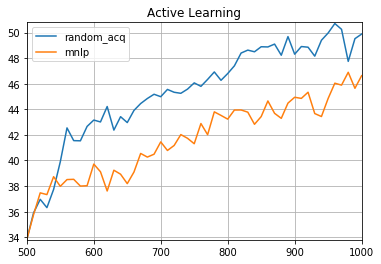

In [22]:
a.plot()

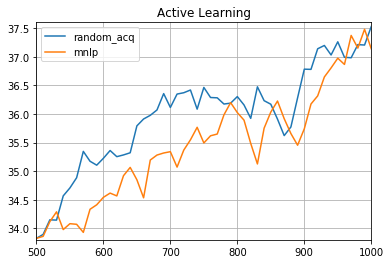

In [19]:
a.plot()

In [11]:
def random_acq(pool_data, num_samples, step=None):
    # return np.random.rand(len(pool_data)) 
    return np.random.choice(len(pool_data), num_samples, replace=False)


class ActiveLearner(object):
    '''Performs active learning'''
    
    def __init__(self, pool_data, pool_labels, test_data, test_labels, 
                 clear_model_fn, train_fn, eval_fn, 
                 save_model, recover_model,
                 init_num_samples=100):
        '''init_num_samples denote how many datapoints to be samples initially, 
        num_smaples denote how many datapoints to be samples at each iteration'''
        
        # train data is python lists not numpy arrays
        # so as to allow datapoints of different lengths like sentences
        # list() expression also takes a deep copy
        self.pool_data = list(pool_data)
        self.pool_labels = list(pool_labels)
        self.test_data = list(test_data)
        self.test_labels = list(test_labels)
        assert (len(self.pool_data)==len(self.pool_labels) and 
               len(self.test_data)==len(self.test_labels)), "data and labels size don't match"
        
        
        self.init_num_samples = init_num_samples
        self.train_fn = train_fn
        self.eval_fn = eval_fn
        
        self.experiment_no = 1 
        
        
        if (self.init_num_samples > len(pool_data)):
            raise Exception('Can not pick more samples than what is available in the pool data')
        
        # initialize empty arrays of dimension (0, 28, 28, 1) etc.
        # self.train_data = np.empty((0,) + self.pool_data.shape[1:])
        # self.train_labels = np.empty((0,) + self.pool_labels.shape[1:])
        self.train_data, self.train_labels = [], []
        
        self._accuracy = []
        self._x_axis = []
        self.acquisition_fn = None
        
        # initial training. 
        # But make sure that the model is cleared of previous training
        clear_model_fn()
        self._init_pick()
        print ('Initial Training')
        self.train_fn(self.train_data, self.train_labels)
        # evaluate the accuracy after initial training
        self._accuracy.append(self.eval_fn(self.test_data, self.test_labels, step=len(self.train_data)))
        self._x_axis.append(len(self.train_data)) # this is over written later and hence useless here!
        
        # Compute summaries over the pool_data
        # compute_pool_data_summary(self.pool_data)
        
        # save model function can be writing the learned model to the disk
        # or even taking a deep copy (in RAM)
        save_model()
        print ('Successfully saved the initial model')
        # we will recover the saved model in case of multiple runs
        self.recover_model = recover_model
    
    def _init_pick(self):
        '''Pick init_number_samples of datapoints from the unsupervised data pool
        for initial training of the model.
        Remove them from the pool and return the data.
        Returns chosen datapoints and the updated pool_data'''

        # np.random.seed(0)
        indices = np.random.choice(range(len(self.pool_data)), self.init_num_samples, replace=False)
        datapoints = [self.pool_data[i] for i in indices] # sadly multi-indexing works in numpy but not in lists
        labels = [self.pool_labels[i] for i in indices]
        # self.pool_data = np.delete(self.pool_data, indices, axis=0)
        # self.pool_labels = np.delete(self.pool_labels, indices, axis=0)
        self._delete_list_indices(self.pool_data, indices)
        self._delete_list_indices(self.pool_labels, indices)
        
        print("Picked " + str(self.init_num_samples) + " datapoints\nSize of updated unsupervised pool = " +
              str(len(self.pool_data)) + "\n")
        
        if (len(self.train_data) > 0):
            raise Exception('In _init_pick: The train data is not empty.')
            
        # self.train_data = np.vstack((self.train_data, datapoints))
        # self.train_labels = np.vstack((self.train_labels, labels))
        self.train_data += list(datapoints)
        self.train_labels += list(labels)
        
    
    def _delete_list_indices(self, l, ind):
        for i in sorted(ind, reverse=True):
            del l[i]
        # In-place delete, so no need to return    
        # return l

    def _active_pick(self, acquisition_fn, step=None):
        """Returns the datapoints which have the highest value as per the acquisition function
        from the pool_data.
        step is an optional argument which can be used for things 
        like changing acquisition function according to iteration number
        """
        # This condition should ideally be False because we have already done the - 
        # necessary checks while initializing run() function
        if (len(self.pool_data) < self.num_samples):
            raise Exception('Fatal mistake: pool data is exhausted')
        
            
        how_many = self.pool_subset_count if self.pool_subset_count <= len(self.pool_data) else len(self.pool_data)
        pool_subset_random_index = np.random.choice(range(len(self.pool_data)), how_many, replace=False)
        X_pool_subset = [self.pool_data[i] for i in pool_subset_random_index]
        y_pool_subset = [self.pool_labels[i] for i in pool_subset_random_index]

        print('Search over Pool of Unlabeled Data size = '+ str(len(X_pool_subset)))

        # acquisition function returns the chosen positions in the passed list
        pos = acquisition_fn(X_pool_subset, self.num_samples, step) 
    
        datapoints = [X_pool_subset[i] for i in pos]
        labels = [y_pool_subset[i] for i in pos]
        # print pool_subset_random_index[:10]
        # self.pool_data = np.delete(self.pool_data, (pool_subset_random_index[pos]), axis=0)
        # self.pool_labels = np.delete(self.pool_labels, (pool_subset_random_index[pos]), axis=0)
        indices = [pool_subset_random_index[i] for i in pos]
        self._delete_list_indices(self.pool_data, indices)
        self._delete_list_indices(self.pool_labels, indices)
        
        print("\nPicked " + str(self.num_samples) + " datapoints\nSize of updated Unsupervised pool = " + 
              str(len(self.pool_data)))

        # self.train_data = np.vstack((self.train_data, datapoints))
        # self.train_labels = np.vstack((self.train_labels, labels))
        self.train_data += list(datapoints)
        self.train_labels += list(labels)

        return len(pos)
    
    
    def run(self, n_iter, acquisition_fn, num_samples=10, pool_subset_count = None):
        '''Run active learning for given number of iterations.
        The acquisition_fn is(are) the name of the function(s) which computes acquisition values.
        aquisition_fn can be a list of function references as well - which is called a multi_run.
        '''
        
        self.num_samples = num_samples # required in _active_pick
        
        if ((pool_subset_count is None) or (pool_subset_count > len(self.pool_data))):
            self.pool_subset_count = pool_subset_count = len(self.pool_data)
        else:
            self.pool_subset_count = pool_subset_count 
        
        if (pool_subset_count < self.num_samples):
            raise Exception("pool subset count can't be smaller than num_samples")
            
        if (n_iter * self.num_samples > len(self.pool_data)):
            raise Exception('Pool data is small.\nReduce the number of iterations or number of samples to pick')
         
        if (type(acquisition_fn) is not list):    
            # if type of aq function is not list then make it a list
            acquisition_fn = [acquisition_fn]   
    
        self.acquisition_fn = acquisition_fn
        
        # self._x_axis = range(self.init_num_samples, self.init_num_samples + self.num_samples*(n_iter+1), self.num_samples)
        self._x_axis = np.zeros((n_iter + 1))
        # initialize _accuracy matrix (2d array)
        self._accuracy = np.zeros((len(acquisition_fn), len(self._x_axis)))

        for i_aq in range(len(acquisition_fn)):
            # recover the model
            self._recover_model_and_data()

            # Do the testing with initial data
            # We could have saved that value, but it is a good check if the model is properly recovered or not
            self._accuracy[i_aq, 0] = self.eval_fn(self.test_data, self.test_labels)
            self._x_axis[0] = self.init_num_samples

            for i in range(n_iter):
                print('\nExperiment ' + str(self.experiment_no) + ' Aquisition function: ' + 
                      str(acquisition_fn[i_aq].__name__) + ': ')
                print('ACQUISITION ITERATION ' + str(i+1) + ' of ' + str(n_iter))
                num = self._active_pick(acquisition_fn[i_aq], step=i)
                # if active_pick doesn't return even a single datapoint, stop
                if (num == 0):
                    break
                
                # allowing non fixed number of samples to be returned from active_pick
                # won't be suitable for running multiple experiments, but it will 
                # record only the last _x_axis
                self._x_axis[i+1] = self._x_axis[i] + num
                
                self.train_fn(self.train_data, self.train_labels)
                self._accuracy[i_aq, i+1] = self.eval_fn(self.test_data, self.test_labels, step=len(self.train_data))
                # assert self._x_axis[i+1] == len(self.train_data)

                # Compute summaries over the pool_data
                # compute_pool_data_summary(self.pool_data, step=len(self.train_data))
        
        return self._x_axis, self._accuracy 
    
    
    
    def _recover_model_and_data(self):
        self.recover_model()
        print ('Recovered Saved Model')
        
        # reset pool_data to the whole data except initial data
        # self.pool_data = np.vstack((self.pool_data, self.train_data[self.init_num_samples:]))
        # self.pool_labels = np.vstack((self.pool_labels, self.train_labels[self.init_num_samples:]))
        self.pool_data += self.train_data[self.init_num_samples:]
        self.pool_labels += self.train_labels[self.init_num_samples:]
        
        # set train data to initially picked data only
        # self.train_data = np.delete(self.train_data, range(self.init_num_samples, len(self.train_data)), axis=0)
        # self.train_labels = np.delete(self.train_labels, range(self.init_num_samples, len(self.train_labels)), axis=0)
        self.train_data = self.train_data[:self.init_num_samples]
        self.train_labels = self.train_labels[:self.init_num_samples]

        
    
    def plot(self, x_axis=None, y_axis=None, label=None, title='Active Learning', loc=0):
        '''Plot the accuracy'''
        %matplotlib inline
        from matplotlib import pyplot as plt
            
        if x_axis is None:
            x_axis = self._x_axis
            y_axis = np.array(self._accuracy)
        
        if len(x_axis) <= 1:
            raise Exception('Please run experiment before plotting!')
        
        x_start = x_axis[0] # self.init_num_samples
        x_end = x_axis[-1]
        y_start = np.round(np.min(y_axis), 1)
        if (y_start > np.min(y_axis)):
            y_start -= 0.1
            
        # y_end = 1.0
        y_end = np.round(np.max(y_axis), 1)
        if (y_end < np.max(y_axis)):
            y_end += 0.1
        
        plt.axis([x_start, x_end, y_start, y_end])

        # no label is given or label doesn't correpond to multi run
        if label is None or len(label) != len(y_axis):
            if (self.acquisition_fn is None):
                raise Exception('Please pass the labels array as an argument')
            label = [s.__name__ for s in self.acquisition_fn]  

        for i in range(len(y_axis)):
             plt.plot(x_axis, y_axis[i], label=label[i])   

        
        plt.grid()
        plt.title(title)
        plt.legend(loc=loc)
        plt.show()  
        
    
    def experiment(self, n_iter, acquisition_fn, num_samples=10, pool_subset_count = None, num_exp=3):
        '''Run the experiments for the given number of times (num_exp) and 
        return average accuracy values over all experiments.'''
        
        if type(acquisition_fn) is not list:
            raise Exception('experiment is to compare different acquisition functions, hence it should be a list')
        
        # define new variables to hold averages: useful incase we want to stop experiment forcefully in between
        self._avg_accuracy = np.zeros((len(acquisition_fn), n_iter+1))
        
        for i in range(num_exp):
            self.experiment_no = i+1
            print ('\nExperiment number : ' + str(self.experiment_no) + '\n****************\n')
            self.run(n_iter, acquisition_fn, num_samples, pool_subset_count)
            self._avg_accuracy = (self._avg_accuracy * (i) + self._accuracy) / (i+1) # running average
        
        # finally assign back the avg accuracy to _accuracy variable for proper plotting
        self._accuracy = self._avg_accuracy
        
        return self._x_axis, self._accuracy 